# MNIST Classification using Convolutional Neural Network (CNN)

This is an introductory CNN project that classifies MNIST data.

The dataset consists of images of size 28 * 28. So, the input to CNN is 28 * 28 image. We will build 2 convolutional layers, each followed by a pooling layer. So, the architecture I will be using is as follows:

Input Layer -> ConvLayer_1 -> MaxPooling_1 -> ConvLayer_2 -> MaxPooling_2 -> Flattened Feature Map -> Fully Connected Layer -> Output (Class scores)

I will use 3 * 3 Filter size for first ConvLayer and 3 * 3 * 3 (depth of 3 to match 3 channels) with a stride of 1 and no padding (might change based on output) and 2 * 2 Pooling size with stride of 2. Also, each ConvLayer will have 3 filters which generate 3 channels of feature map. Finally, the feature map from last pooling layer is flattened and fed to the fully connected layer. The fully connected layer will perform same operation as in feed-forward neural networks. I will use RELU activation for hidden layer and Softmax for output layer.

The size of feature map can be calculated as: 
((Input Size - Receptive Field Size) + 2 * Zero Padding) / (Stride + 1)

In [1]:
import struct
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Load Dataset

In [3]:
def load_mnist_images_manual(image_path, label_path):
    with open (image_path, 'rb') as img_file:
        # Read the header
        magic, num_images, rows, cols = struct.unpack('>IIII', img_file.read(16))

        print(f"Magic: {magic}, Number of Images: {num_images}, Rows: {rows}, Columns: {cols}")

        # Read the image data
        image_data = img_file.read(rows * cols * num_images)
        images = torch.frombuffer(image_data, dtype=torch.uint8)

        images = images.reshape((num_images, rows, cols))

    with open (label_path, 'rb') as lbl_file:
        # Read the header
        magic, num_labels = struct.unpack('>II', lbl_file.read(8))

        print(f"Magic: {magic}, Number of Labels: {num_labels}")

        # Read the label data
        label_data = lbl_file.read(num_labels)
        labels = torch.frombuffer(label_data, dtype=torch.uint8)

    return images, labels

In [4]:
# Display some random images
import matplotlib.pyplot as plt
import math

def display_images(images, labels):
    cols = 4
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(20, 10))
    index = 0

    for x in zip(images, labels):
        image = x[0]
        label = x[1]
        plt.subplot(rows, cols, index + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        index += 1

## Define Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## Define CNN

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution Layer 1
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0)
        self.relu_1 = nn.ReLU()
 
        # Max Pooling 1
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Layer 2
        self.conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=0)
        self.relu_2 = nn.ReLU()

        # Max Pooling 2
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flattening layer
        self.flatten = nn.Flatten(start_dim=1)

        # Fully Connected 1
        self.fc_1 = nn.Linear(in_features=3 * 4 * 4, out_features=24)
        self.fc_1_relu = nn.ReLU()

        # Fully Connected 2
        self.fc_2 = nn.Linear(in_features=24, out_features=10)

        # CrossEntropyLoss implicitly implements LogSoftmax, so don't need this activation.
        # self.fc_2_softmax = nn.Softmax(dim=1)

    def forward(self, X):
        # Convolution 1
        out = self.conv_layer_1(X)
        out = self.relu_1(out)

        # Max Pooling 1
        out = self.max_pool_1(out)

        # Convolution 2
        out = self.conv_layer_2(out)
        out = self.relu_2(out)

        # Max Pooling 2
        out = self.max_pool_2(out)

        # Flatten
        out = out.view(out.size(0), -1)

        # Fully Connected 1
        out = self.fc_1(out)
        out = self.fc_1_relu(out)

        # Fully Connected 2
        out = self.fc_2(out)
        # out = self.fc_2_softmax(out) // CrossEntropyLoss implicitly implements LogSoftmax

        return out

## Initialize hyperparameters

In [7]:
batch_size = 64
total_epoch = 100
learning_rate = 0.001

## Training model

In [8]:
X_train, y_train = load_mnist_images_manual("dataset/train-images.idx3-ubyte", "dataset/train-labels.idx1-ubyte")

X_train = X_train.to(device)
y_train = y_train.to(device)

Magic: 2051, Number of Images: 60000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 60000


C:\Users\sujan\AppData\Local\Temp\ipykernel_22452\2397727395.py:10: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:1567.)
  images = torch.frombuffer(image_data, dtype=torch.uint8)


In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([60000, 28, 28])
y_train shape: torch.Size([60000])


In [10]:
train_data = CustomDataset(X_train, y_train)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [11]:
cnn_model = CNNModel()

In [12]:
error = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

In [13]:
# CNN Training

num_of_iterations = X_train.shape[0] // batch_size

training_start_time = time.time()

count = 0
loss_list = []
iteration_list = []

for epoch in range(total_epoch):
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.float()
        images = images.unsqueeze(1)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model.forward(images)

        # Calculate loss
        loss = error(outputs, labels)

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1
        loss_list.append(loss.data)
        iteration_list.append(count)

        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{total_epoch}], Step [{i + 1}/{num_of_iterations}], Loss: {loss.item():.4f}")

training_end_time = time.time()

print(f"\nTotal training time: {(training_end_time - training_start_time)} seconds.")

Epoch [1/100], Step [1/937], Loss: 15.4330 


Epoch [1/100], Step [101/937], Loss: 2.3277 


Epoch [1/100], Step [201/937], Loss: 2.2789 


Epoch [1/100], Step [301/937], Loss: 2.2569 


Epoch [1/100], Step [401/937], Loss: 2.1104 


Epoch [1/100], Step [501/937], Loss: 1.8487 


Epoch [1/100], Step [601/937], Loss: 1.7049 


Epoch [1/100], Step [701/937], Loss: 1.2059 


Epoch [1/100], Step [801/937], Loss: 1.3471 


Epoch [1/100], Step [901/937], Loss: 0.9729 


Epoch [2/100], Step [1/937], Loss: 0.7683 


Epoch [2/100], Step [101/937], Loss: 0.9307 


Epoch [2/100], Step [201/937], Loss: 0.6847 


Epoch [2/100], Step [301/937], Loss: 0.5848 


Epoch [2/100], Step [401/937], Loss: 0.5332 


Epoch [2/100], Step [501/937], Loss: 0.4474 


Epoch [2/100], Step [601/937], Loss: 0.5922 


Epoch [2/100], Step [701/937], Loss: 0.5172 


Epoch [2/100], Step [801/937], Loss: 0.2761 


Epoch [2/100], Step [901/937], Loss: 0.4362 


Epoch [3/100], Step [1/937], Loss: 0.5034 


Epoch [3/100], Ste

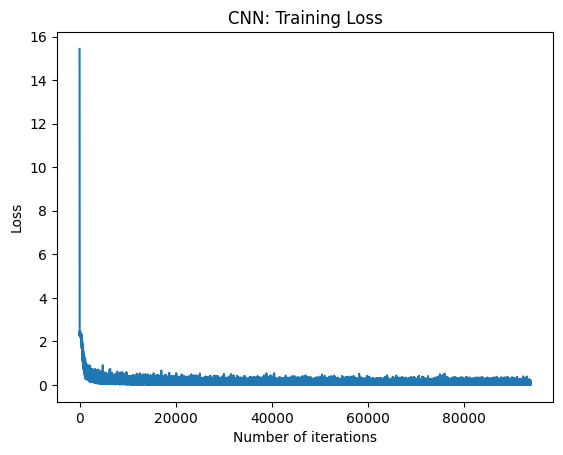

In [14]:
# Loss Visualization

plt.plot(iteration_list, loss_list)

plt.xlabel("Number of iterations")
plt.ylabel("Loss")

plt.title("CNN: Training Loss")

plt.show()

## Evaluation

In [15]:
X_test, y_test = load_mnist_images_manual("dataset/t10k-images.idx3-ubyte", "dataset/t10k-labels.idx1-ubyte")

X_test = X_test.to(device)
y_test = y_test.to(device)

Magic: 2051, Number of Images: 10000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 10000


In [16]:
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test}")

X_test Shape: torch.Size([10000, 28, 28])
y_test Shape: tensor([7, 2, 1,  ..., 4, 5, 6], dtype=torch.uint8)


In [17]:
test_data = CustomDataset(X_test, y_test)

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [18]:
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for i, (images, labels) in enumerate(test_dataloader):
        images = images.float()
        images = images.unsqueeze(1)
        
        outputs = cnn_model.forward(images)
        _, predictions = torch.max(outputs, 1)

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.shape[0]

print(f"Total correct predictions: {total_correct} \n Total Samples: {total_samples}")
print(f"Accuracy: {total_correct / total_samples * 100:.3f}")

Total correct predictions: 9753 
 Total Samples: 10000
Accuracy: 97.530
